In [1]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from scipy import ndimage
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import shift
from scipy.ndimage import map_coordinates
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from scipy.ndimage import gaussian_filter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

2024-12-10 09:44:53.313703: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 09:44:53.337219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 09:44:53.355246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 09:44:53.360366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 09:44:53.375068: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [5]:
def create_dataset(img_folder, label):
    image_batch = []  
    for file in tqdm(os.listdir(img_folder)):
        image_path= os.path.join(img_folder, file)
        image= cv2.imread(image_path)[:,:,::-1]
        image=cv2.resize(image, (128, 128),interpolation = cv2.INTER_AREA)   
        # image [image<0] = 0
        img_nor = image / 255.0  ##np.max(image)
        image=np.array(img_nor, dtype = np.float32)
        image_batch.append(np.array(image, np.float32))
        
    image_batch = np.array((image_batch), np.float32)
    train, test = train_test_split(image_batch, test_size=0.3, random_state=7)
    train_images = train.reshape(-1, 128, 128, 3)
    train_label = np.full(len(train_images), label)
    test_images = test.reshape(-1, 128, 128, 3)
    test_label = np.full(len(test_images), label)
    return train_images, train_label, test_images, test_label

def complete_data(full_datapath):
    label = 0
    for dir_name in os.listdir(full_datapath):
        data_path = os.path.join(full_datapath, dir_name)
        #print(data_path)
        print(f"class {label} is associated with directory: {dir_name}")
        train_images, train_label, test_images, test_label = create_dataset(data_path, label)
        label+=1
        if label == 1:
            train_data = train_images
            train_class = train_label
            test_data = test_images
            test_class = test_label
        else:
            train_data = np.concatenate((train_data, train_images))
            train_class = np.concatenate((train_class, train_label))
            test_data = np.concatenate((test_data, test_images))
            test_class = np.concatenate((test_class, test_label))
            del train_images
            del train_label
            del test_images
            del test_label
    return train_data, train_class, test_data, test_class
    
x_train, y_train, x_test, y_test = complete_data(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset')
print(f"x_training data shape: {x_train.shape} and test data shape: {x_test.shape}: ")
print(f"x_training label shape: {y_train.shape} and test label shape: {y_test.shape}: ")

y_test_encoded = to_categorical(y_test)
print(y_test_encoded.shape)

class 0 is associated with directory: basophil


100%|███████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:48<00:00, 25.20it/s]


class 1 is associated with directory: eosinophil


100%|███████████████████████████████████████████████████████████████████████████████| 3117/3117 [02:03<00:00, 25.23it/s]


class 2 is associated with directory: erythroblast


100%|███████████████████████████████████████████████████████████████████████████████| 1551/1551 [00:57<00:00, 27.02it/s]


class 3 is associated with directory: ig


100%|███████████████████████████████████████████████████████████████████████████████| 2895/2895 [01:49<00:00, 26.36it/s]


class 4 is associated with directory: lymphocyte


100%|███████████████████████████████████████████████████████████████████████████████| 1214/1214 [00:46<00:00, 26.30it/s]


class 5 is associated with directory: monocyte


100%|███████████████████████████████████████████████████████████████████████████████| 1420/1420 [00:53<00:00, 26.50it/s]


class 6 is associated with directory: neutrophil


100%|███████████████████████████████████████████████████████████████████████████████| 3329/3329 [02:09<00:00, 25.65it/s]


class 7 is associated with directory: platelet


100%|███████████████████████████████████████████████████████████████████████████████| 2348/2348 [01:29<00:00, 26.18it/s]


x_training data shape: (11960, 128, 128, 3) and test data shape: (5132, 128, 128, 3): 
x_training label shape: (11960,) and test label shape: (5132,): 
(5132, 8)


In [6]:
np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/train_data.npy', x_train)
np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/train_label.npy', y_train)
np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_data.npy', x_test)
np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_label_enc.npy', y_test_encoded)

In [ ]:
# x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/train_data.npy')
# y_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/train_label.npy')
# x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_data.npy')
# y_test_enc = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/PBC_dataset/test_label_enc.npy')

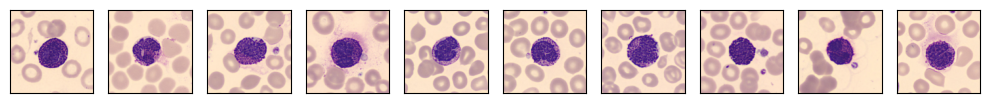

In [7]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x_train[i] * 255).astype(np.uint8))
plt.show()

In [8]:
## Perform horizontal and vertical flips
x_train_hflip = np.flip(x_train, axis=2)  # Horizontal flip (flip along width)
y_train_hflip = y_train
x_train_vflip = np.flip(x_train, axis=1)  # Vertical flip (flip along height)
y_train_vflip = y_train

## Combine original and augmented data
x_train_augmented = np.concatenate((x_train, x_train_hflip, x_train_vflip), axis=0)
y_train_augmented = np.concatenate((y_train, y_train_hflip, y_train_vflip), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

Original dataset shape: (11960, 128, 128, 3)
Augmented dataset shape: (35880, 128, 128, 3)
Augmented label shape: (35880,)


In [9]:
del x_train_hflip
del x_train_vflip

In [10]:
def translate_image(image, shift_x, shift_y):
    """
    Translate the image by shift_x and shift_y.
    Uses constant fill for pixels outside boundaries.
    """
    return shift(image, shift=(shift_y, shift_x, 0), mode='constant', cval=0.0)

# Create translated datasets
x_train_translated_pos = np.array([translate_image(img, 20, 20) for img in tqdm(x_train)])  # +20 pixels in both directions
y_train_tpos = y_train
x_train_translated_neg = np.array([translate_image(img, -20, -20) for img in tqdm(x_train)])  # -20 pixels in both directions
y_train_tneg = y_train

# Combine original and translated data
x_train_augmented = np.concatenate((x_train_augmented, x_train_translated_pos, x_train_translated_neg), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_tpos, y_train_tneg), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 11960/11960 [03:11<00:00, 62.51it/s]


Original dataset shape: (11960, 128, 128, 3)
Augmented dataset shape: (59800, 128, 128, 3)
Augmented label shape: (59800,)


In [11]:
del x_train_translated_pos
del x_train_translated_neg

In [12]:
def scale_image(image, scale_factor):
    """
    Scale the image by a given scale factor.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    scaled_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Crop or pad the image back to the original size
    if scale_factor > 1:
        # Crop center
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        return scaled_image[start_h:start_h + h, start_w:start_w + w]
    else:
        # Pad with zeros
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        return np.pad(
            scaled_image,
            ((pad_h, h - new_h - pad_h), (pad_w, w - new_w - pad_w), (0, 0)),
            mode='constant',
            constant_values=0
        )

# Apply scaling
x_train_scaled_up = np.array([scale_image(img, 1.10) for img in tqdm(x_train)])  # +2% scaling
y_train_scaled_up = y_train
x_train_scaled_down = np.array([scale_image(img, 0.90) for img in tqdm(x_train)])  # -2% scaling
y_train_scaled_down = y_train

# Combine original and scaled datasets
x_train_augmented = np.concatenate((x_train_augmented, x_train_scaled_up, x_train_scaled_down), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_scaled_up, y_train_scaled_down), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

100%|██████████████████████████████████████████████████████████████████████████| 11960/11960 [00:00<00:00, 11960.78it/s]


Original dataset shape: (11960, 128, 128, 3)
Augmented dataset shape: (83720, 128, 128, 3)
Augmented label shape: (83720,)


In [13]:
del x_train_scaled_up
del x_train_scaled_down

In [34]:
def elastic_transform_2d(image, alpha, sigma=8, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)
    #print(random_state)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')  #wrap,reflect, nearest
    return distored_image.reshape(image.shape)

img_aug_array=[]
label_array = []
alphas = [900, 600]
for d in tqdm(range(len(x_train))):
    for e in range (2):
            volume = elastic_transform_2d(x_train[d], alpha=alphas[e])
            img_aug_array.append(volume)
            label = y_train[d]
            label_array.append(label)
        
x_aug_et = np.array(img_aug_array, np.float32)
x_train_augmented = np.concatenate((x_train_augmented, x_aug_et), axis=0)
y_aug = np.array(label_array, np.float32)
y_train_augmented = np.concatenate((y_train_augmented, y_aug), axis=0)
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented labelshape:", y_train_augmented.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 11960/11960 [04:41<00:00, 42.53it/s]


Original dataset shape: (11960, 128, 128, 3)
Augmented dataset shape: (107640, 128, 128, 3)
Augmented labelshape: (107640,)


In [28]:
del x_aug_et

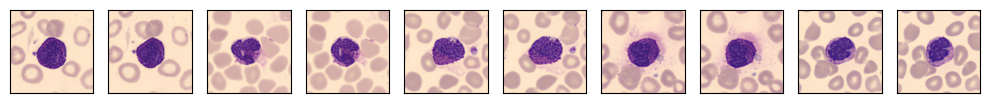

In [35]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x_aug_et[i] * 255).astype(np.uint8))
plt.show()

In [36]:
y_train_encoded = to_categorical(y_train_augmented)
y_train_encoded.shape

(107640, 8)

In [37]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x

def DenseNet121(input_shape=(128, 128, 3), num_classes=8):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = DenseNet121()
#model.summary()

I0000 00:00:1733850359.474304   68410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850359.710505   68410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850359.710613   68410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850359.726072   68410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850359.726145   68410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [38]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip((y_true) * (y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives + K.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) 
    return true_negatives / (possible_negatives + K.epsilon())

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
    
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=10000,
    decay_rate=0.1) #should be < 1, otherwise lr rate increases

optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)


model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])  ##if not one-hot encoded use: SparseCategoricalCrossentropy

In [39]:
filepath = '/mnt/c/Users/Dhruba/Codes/saved models/PBC_wght_dns.ep{epoch:02d}-test_acc_{val_accuracy:.3f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

y_train_int = np.argmax(y_train_encoded, axis=1)
## Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

result = model.fit(x=x_train_augmented,
                    y=y_train_encoded,
                    batch_size = 40,
                    epochs = 18,
                    verbose = 1,
                    validation_data = (x_test, y_test_encoded),
                    callbacks=[checkpoint],
                    class_weight=class_weights_dict,### results in poor accuracy 
                    shuffle=True)

Class Weights: {0: 1.7546948356807512, 1: 0.6854653828519028, 2: 1.3778801843317972, 3: 0.7379072063178678, 4: 1.7608951707891638, 5: 1.5040241448692153, 6: 0.6416309012875536, 7: 0.9099208764455264}
Epoch 1/18


I0000 00:00:1733850585.017524   70465 service.cc:146] XLA service 0x7f62d8039a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733850585.017621   70465 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-12-10 11:09:46.399015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 11:09:51.577872: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-10 11:11:10.334036: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_69', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1733850670.836234   70465 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7568 - loss: 0.7663

2024-12-10 11:14:35.108240: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 8 bytes spill stores, 8 bytes spill loads

2024-12-10 11:14:35.676628: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 180 bytes spill stores, 180 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.39458, saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_wght_dns.ep01-test_acc_0.395.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 352s 83ms/step - accuracy: 0.7568 - loss: 0.7662 - val_accuracy: 0.3946 - val_loss: 4.0748
Epoch 2/18
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9550 - loss: 0.1276
Epoch 2: val_accuracy improved from 0.39458 to 0.80768, saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_wght_dns.ep02-test_acc_0.808.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 199s 74ms/step - accuracy: 0.9550 - loss: 0.1276 - val_accuracy: 0.8077 - val_loss: 0.8153
Epoch 3/18
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9725 - loss: 0.0759
Epoch 3: val_accuracy improved from 0.80768 to 0.90822, saving model to /mnt/c/Users/Dhruba/Codes/saved models/PBC_wght_dns.ep03-test_acc_0.908.keras
2691/2691 ━━━━━━━━━━━━━━━━━━━━ 201s 75ms/step - accuracy: 0.9725 - loss: 0.0759 - val_accuracy: 0.9082 - val_loss: 0.3084
Epoch 4/

KeyboardInterrupt: 

In [40]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/PBC_wght_dns.ep04-test_acc_0.972.keras', compile = True)
#best_model.summary()

In [41]:
best_model.evaluate(x_test, y_test_encoded, batch_size=40, verbose=1)

129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9756 - loss: 0.0978


[0.10746689140796661, 0.9719407558441162]

In [42]:
y_pred = best_model.predict(x_test, batch_size=40,  verbose=0)

sparse_gt = np.argmax(y_test_encoded, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
#print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)
# # Calculate precision, recall, and F1-score for each class
# precision = precision_score(y, sparse_pred, average=None)
# recall = recall_score(y, sparse_pred, average=None)
# f1 = f1_score(y, sparse_pred, average=None)

# # Calculate macro, micro, and weighted scores
# macro_f1 = f1_score(y, sparse_pred, average='macro')
# micro_f1 = f1_score(y, sparse_pred, average='micro')
# weighted_f1 = f1_score(y, sparse_pred, average='weighted')

Accuracy of model on full test data:  0.9719407638347622
Macro-averaged AUC on full test data:  0.999246781307608
Micro-averaged AUC on full test data:  0.9991397737737319


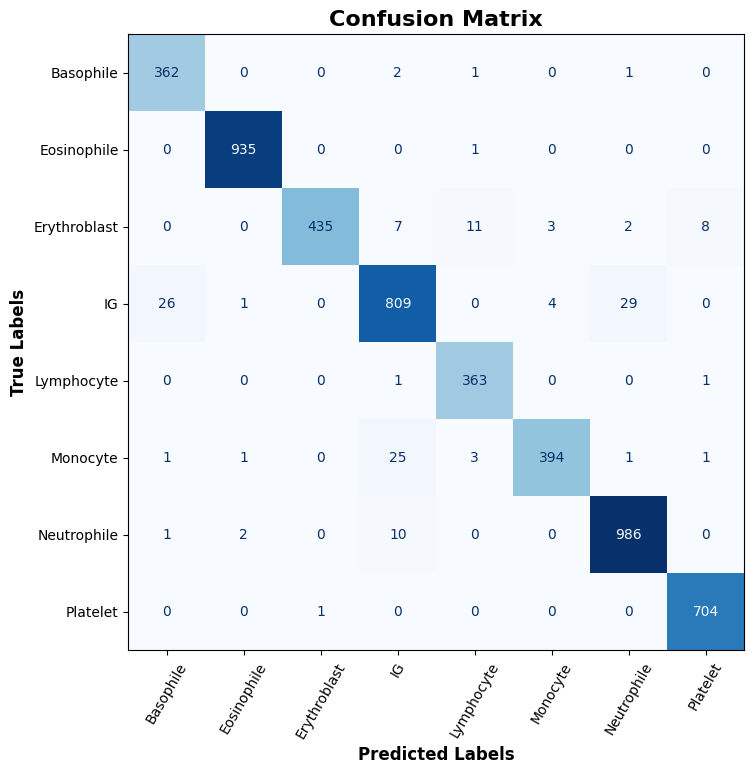

In [49]:
class_names = ['Basophile', 'Eosinophile', 'Erythroblast', 'IG', 'Lymphocyte', 'Monocyte', 'Neutrophile', 'Platelet']
plt.figure(figsize=(8, 8))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
## Rotate x-axis labels
plt.xticks(rotation=60)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')

#plt.tight_layout()
plt.show()

In [51]:
# Print classification report
report = classification_report(sparse_gt, sparse_pred, target_names=[f"Class {i}" for i in range(8)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96       366
     Class 1       1.00      1.00      1.00       936
     Class 2       1.00      0.93      0.96       466
     Class 3       0.95      0.93      0.94       869
     Class 4       0.96      0.99      0.98       365
     Class 5       0.98      0.92      0.95       426
     Class 6       0.97      0.99      0.98       999
     Class 7       0.99      1.00      0.99       705

    accuracy                           0.97      5132
   macro avg       0.97      0.97      0.97      5132
weighted avg       0.97      0.97      0.97      5132



In [ ]:
# Specify the folder containing the .keras files
folder_path = "/mnt/c/Users/Dhruba/Codes/saved models"
split_num = 40

# Use glob to find all .keras files in the folder
keras_files = glob.glob(os.path.join(folder_path, "*.keras"))
# Iterate through each file
for file_path in keras_files:
    print(file_path)
    best_model = load_model(file_path, compile = True)
    accuracy_list = []
    CM = []
    mac_auc = []
    mic_auc = [] 
    Y = []
    Pred = []
    for i in tqdm(range(split_num)):  
        x = splits[i][0]
        y = splits[i][1]
        
        y_pred = best_model.predict(x, batch_size=40,  verbose=0)
        sparse_pred = np.argmax(y_pred, axis=1)
        
        ### Calculate accuracy
        accuracy = accuracy_score(y, sparse_pred)
        #print("Accuracy:", accuracy)
        accuracy_list.append(accuracy)
    
        cm = confusion_matrix(y, sparse_pred)
        CM.append(cm)
    
        # Calculate macro-averaged AUC
        macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
        mac_auc.append(macro_auc)
        # Calculate micro-averaged AUC
        micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
        mic_auc.append(micro_auc)
       
        Y.append(y)
        Pred.append(sparse_pred)
    total_acc = sum(accuracy_list[:split_num])/split_num
    print("Accuracy of model on full test data: ", total_acc)
    
    macro_auc = sum(mac_auc[:split_num])/split_num
    print("Macro-averaged AUC on full test data: ", macro_auc)
    
    micro_auc = sum(mic_auc[:split_num])/split_num
    print("Micro-averaged AUC on full test data: ", micro_auc)

/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep01-test_acc_0.76.keras


  0%|                                                                                            | 0/40 [00:00<?, ?it/s]2024-11-28 20:07:21.845709: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5699', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 20:07:22.348130: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5699', 172 bytes spill stores, 172 bytes spill loads

2024-11-28 20:07:36.995885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5699', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 20:07:37.263698: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

Accuracy of model on full test data:  0.7165193305919668
Macro-averaged AUC on full test data:  0.9679336189353684
Micro-averaged AUC on full test data:  0.9771281610993425
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep02-test_acc_0.88.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.05s/it]


Accuracy of model on full test data:  0.5077875342052265
Macro-averaged AUC on full test data:  0.9593947121267306
Micro-averaged AUC on full test data:  0.9458869186446602
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep03-test_acc_0.95.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.08s/it]


Accuracy of model on full test data:  0.7783282829594882
Macro-averaged AUC on full test data:  0.9824697065533057
Micro-averaged AUC on full test data:  0.9859810229024205
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep04-test_acc_0.98.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]


Accuracy of model on full test data:  0.838250133604501
Macro-averaged AUC on full test data:  0.9804139383481016
Micro-averaged AUC on full test data:  0.9915077628826312
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep05-test_acc_0.99.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.28s/it]


Accuracy of model on full test data:  0.8500299991587864
Macro-averaged AUC on full test data:  0.9825798427482537
Micro-averaged AUC on full test data:  0.9918700602902666
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep06-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:18<00:00,  1.97s/it]


Accuracy of model on full test data:  0.860766852723305
Macro-averaged AUC on full test data:  0.9837745392753418
Micro-averaged AUC on full test data:  0.992458239788049
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep07-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.21s/it]


Accuracy of model on full test data:  0.8524679101781889
Macro-averaged AUC on full test data:  0.9829126854295508
Micro-averaged AUC on full test data:  0.9925181505094953
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep08-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.21s/it]


Accuracy of model on full test data:  0.8583085608321086
Macro-averaged AUC on full test data:  0.9844072445706098
Micro-averaged AUC on full test data:  0.9916866558248495
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep09-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.22s/it]


Accuracy of model on full test data:  0.8645230876000178
Macro-averaged AUC on full test data:  0.9853557705429392
Micro-averaged AUC on full test data:  0.9925690551341748
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep10-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.23s/it]


Accuracy of model on full test data:  0.864797750001237
Macro-averaged AUC on full test data:  0.9822542936725809
Micro-averaged AUC on full test data:  0.9923295920728128
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep11-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:24<00:00,  2.12s/it]


Accuracy of model on full test data:  0.8669413754583376
Macro-averaged AUC on full test data:  0.9843251024335853
Micro-averaged AUC on full test data:  0.9921080740925335
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep12-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:33<00:00,  2.33s/it]


Accuracy of model on full test data:  0.8670006160651991
Macro-averaged AUC on full test data:  0.9840054785832724
Micro-averaged AUC on full test data:  0.9921830222212277
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep13-test_acc_1.00.keras


 40%|█████████████████████████████████▏                                                 | 16/40 [00:55<00:48,  2.02s/it]